# Parks
This dataset hosts geographical data regarding parks in Pittsburgh.

## Datasets
[City of Pittsburgh Parks](https://data.wprdc.org/dataset/parks) and [Parks](https://data.wprdc.org/dataset/parks1)

## Metric
For the purposes of this notebook, a neighborhood is considered better than another if it has a higher acreage of parks than the other.

## Code

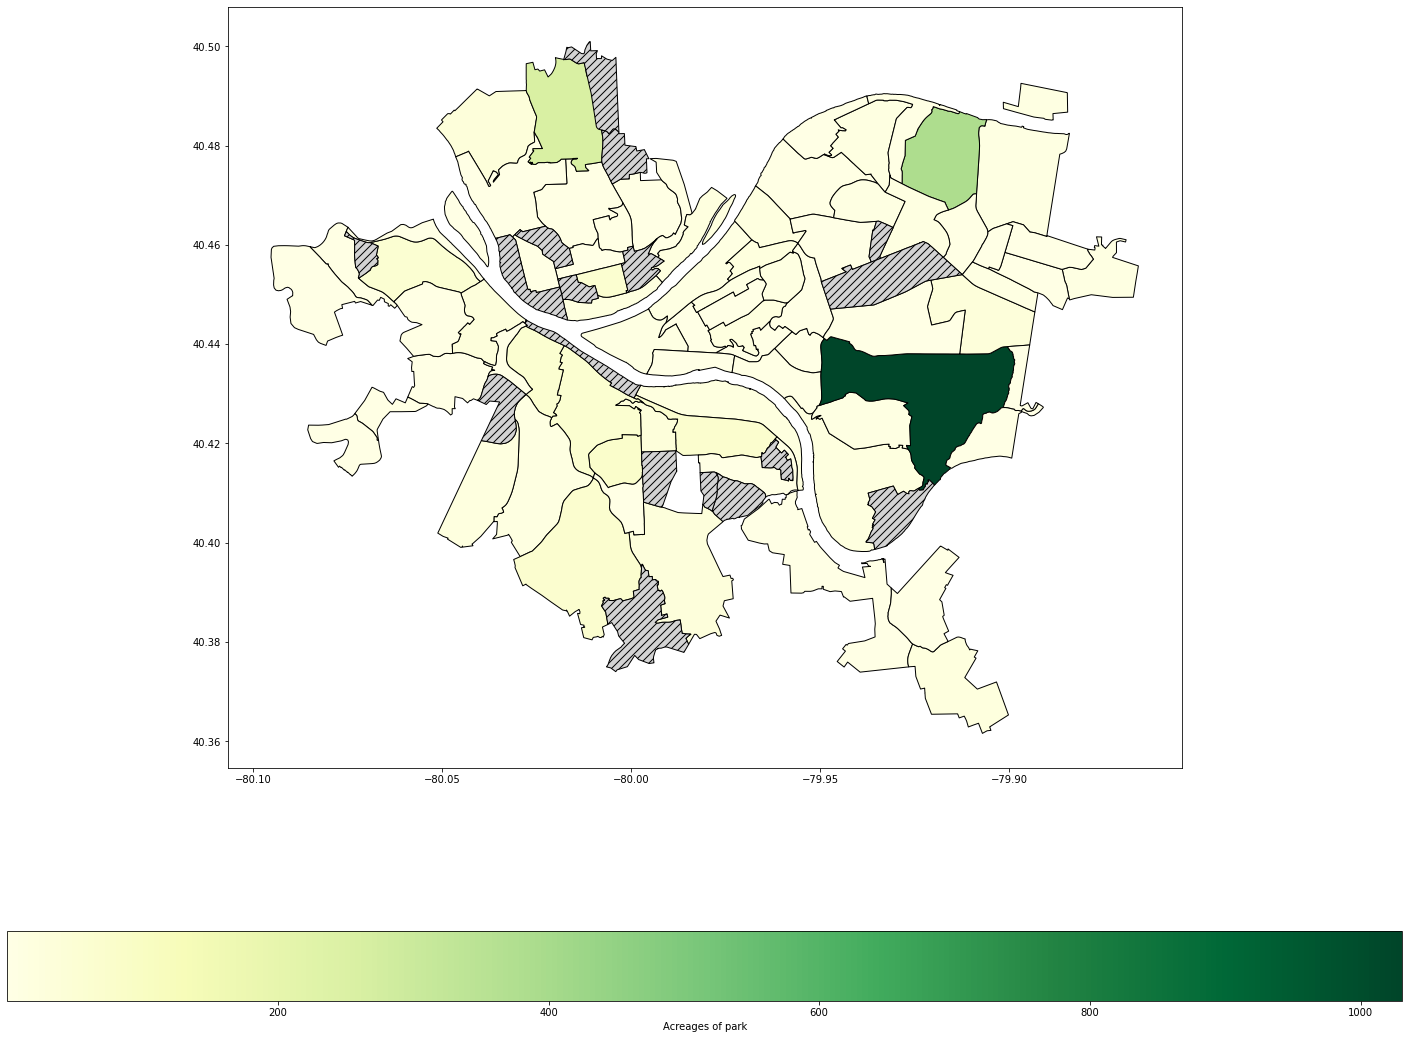

In [29]:
import pandas as pd
import geopandas as gpd
import matplotlib as plt
import sys
%matplotlib inline   

# CSV Imports
city_parks = pd.read_csv('city_parks.csv')
parks = pd.read_csv('parks.csv')

# Shapefile imports (used by geopandas to make maps)
parks_shape = gpd.read_file('Parks.shp')
neighborhoods = gpd.read_file('../neighborhood/Neighborhoods_.shp')

# Merge the dataframes on the park names (which is shared across datasets), 
# we'll use this to eventually group by neighborhood
# and then gather location and area data.
merged_parks = pd.merge(city_parks, parks, on='name')
# Then get the acreage out of those and sort descending, so the neighborhood
# with the highest acreage of park comes out on top.
acreages = merged_parks.groupby('neighborhood')['acreage'].sum().sort_values(ascending=False)

# Finally make a map merging neighborhood information with the acreage information we got from the dataframes.
acres_map_df = neighborhoods.merge(acreages.rename('acreage'), how='left', left_on='hood', right_on='neighborhood')
acres_map = acres_map_df.plot(
               column='acreage',
               cmap='YlGn',
               edgecolor='black', 
               legend=True, 
               legend_kwds={'label':'Acreages of park', 'orientation':'horizontal'}, 
               figsize=(25,20),
               missing_kwds={'color':"lightgrey", "hatch":"///"}
              )

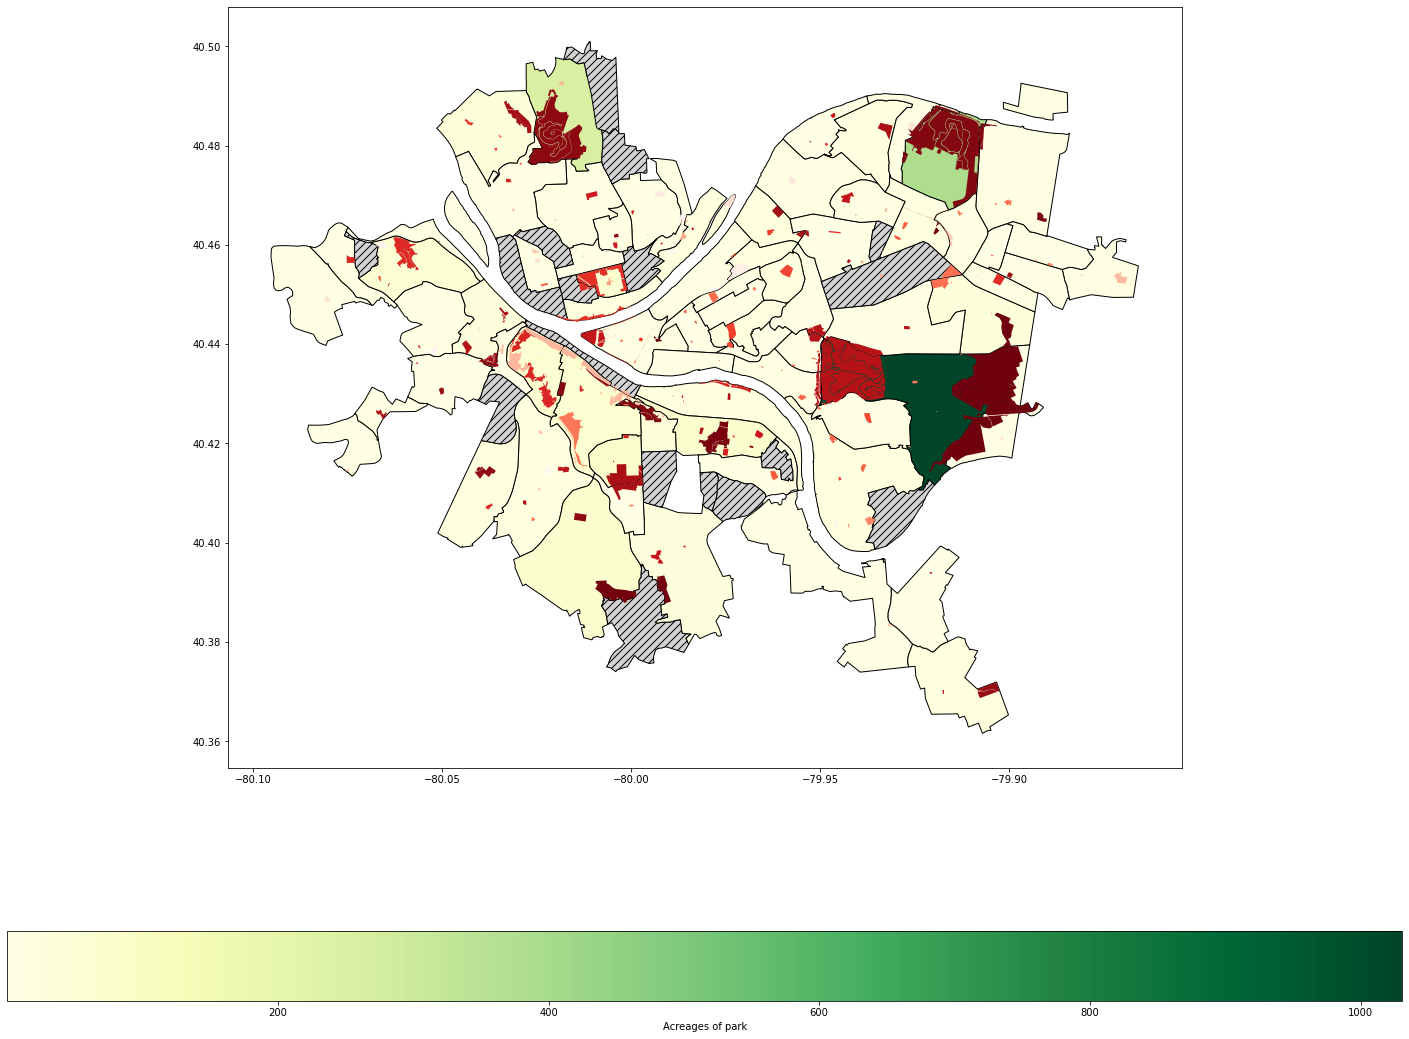

In [36]:
acres_map = acres_map_df.plot(
               column='acreage',
               cmap='YlGn',
               edgecolor='black', 
               legend=True, 
               legend_kwds={'label':'Acreages of park', 'orientation':'horizontal'}, 
               figsize=(25,20),
               missing_kwds={'color':"lightgrey", "hatch":"///"}
              )
# And here is a map with the actual parks overlayed onto it:
parks_map = parks_shape.plot(ax=acres_map, figsize=(25,20), cmap='Reds')

## Charts

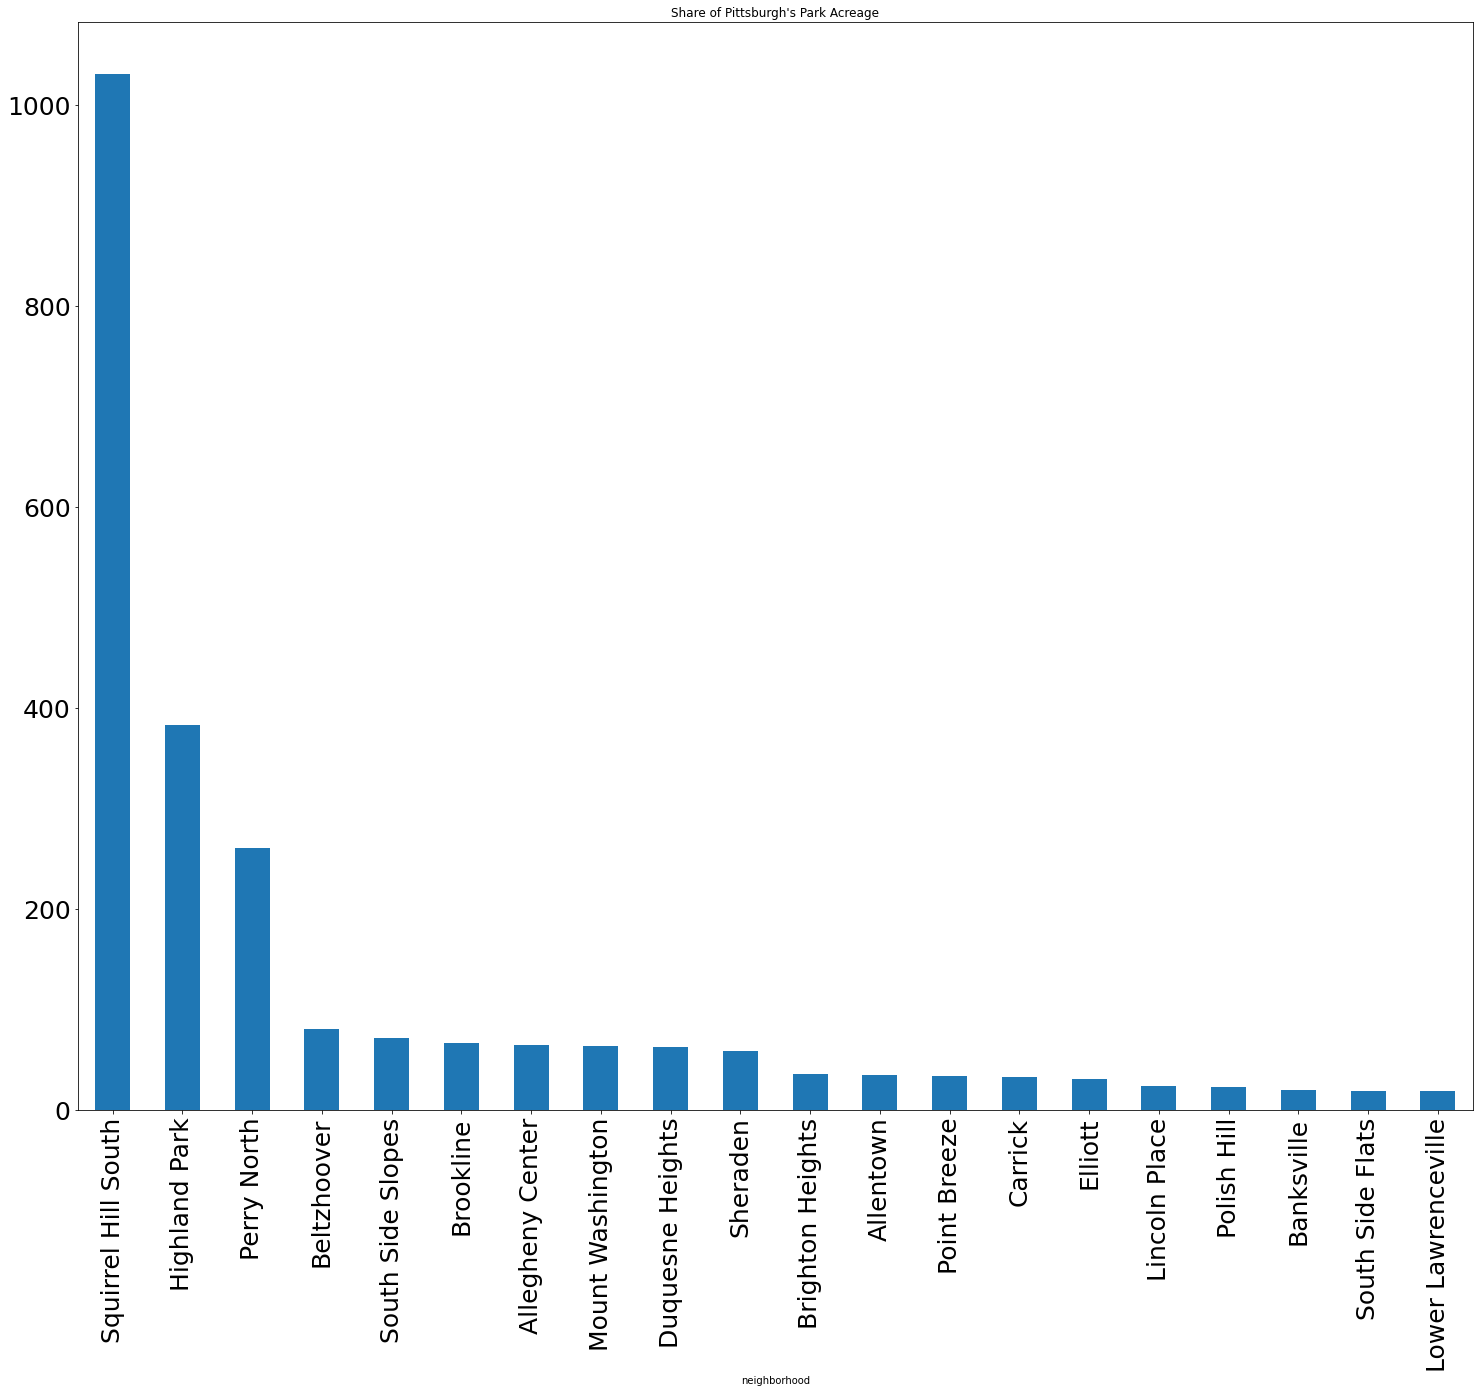

In [34]:
# Note that only the first 20 are shown for simplicity of the chart, but the trend continues asymptotically down.
acreages.head(20).plot(kind='bar',
                       fontsize=25,
                       x='neighborhood',
                       y='acres',
                       figsize=(25,20),
                       title="Share of Pittsburgh's Park Acreage")

## Data as Table

In [14]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(acreages)

neighborhood
Squirrel Hill South          1030.808354
Highland Park                 383.018646
Perry North                   260.202754
Beltzhoover                    80.150916
South Side Slopes              71.245957
Brookline                      66.260736
Allegheny Center               63.911119
Mount Washington               63.311366
Duquesne Heights               62.375866
Sheraden                       58.629922
Brighton Heights               35.231589
Allentown                      34.248390
Point Breeze                   33.381284
Carrick                        32.136299
Elliott                        30.682895
Lincoln Place                  23.363557
Polish Hill                    22.564513
Banksville                     19.211646
South Side Flats               18.308014
Lower Lawrenceville            18.227576
Hazelwood                      17.575403
North Shore                    17.348433
Troy Hill                      17.256598
Terrace Village                16.915847
Bee

# Analysis

As is apparent from the data, the top three neighborhoods for this metric are
1. Squirrel Hil South (*by a large margin*)
2. Highland Park
3. Perry North
The bar chart shows that a huge drop off is incurred in acreage for every neighborhood after these three, quickly creating an almost asymptotic trend. 

## Special Note

Something especially interesting can be realized when overlaying the geographic locations of the parks onto the underlying map of that the acreage data creates. It can be seen that several neighborhoods perform very poorly on the first map (that is, they have very low acreage levels) despite being physically extremely close to a significant amount of park. This is because the dataset itself *only* tracks acreage of park that is actually included in the borders of a neighborhood. But, imagine living on the edge of Squirrel Hill South, just over its border. It would be fair to say that your neighborhood does not *contain* as much park as Squirrel Hill South, but you have significantly more *physical access* to high acreages of park than someone much further away with little park in their own neighborhood as well. 

I could not come up with a simple way to resolve this discrepancy between the data and its implications at first, but I did eventually come up with a somewhat complicated idea. If the neighborhoods were represented as graph vertices that stored an acreage value, and then every vertex was connected to each other vertex (a "dense" graph) by edges that had weights equal to the distance from the latitude/longitude coordinates between each neighborhood (these are collected from the approximate center of the neighborhoods, and are present in one of the neighborhood datasets), then one could actually reassign the acreage values in the datasets to more accurately reflect access. To do this, I planned on running an algorithm to follow every path from each neighborhood to each *other* neighborhood, adding the acreages of each node, multiplied by a fraction created using the edge weight of this path (which is the distance from the source neighborhood to destination neighborhood). Note that the distance from a neighborhood to itself would then be considered 1, instead of 0, to prevent dividing by zero in this algorithm. 

As of writing, I have not been successful at implementing this, but you can see my attempts in `Parks-with-Graph.ipynb`. 